# IMPORTS

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


# CONFIGURAÇÕES

In [5]:
DATA_DIR = "data/raw"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
SEED = 123


# DATASET CORRETO

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes reais:", class_names)


Found 3346 files belonging to 3 classes.
Using 2677 files for training.
Found 3346 files belonging to 3 classes.
Using 669 files for validation.
Classes reais: ['covid', 'normal', 'pneumonia']


# NORMALIZAÇÃO CORRETA (MobileNetV2)

In [7]:
def preprocess(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(AUTOTUNE)


# CLASS WEIGHT CORRETO

In [8]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.6964512040557669), 1: np.float64(0.8277674706246135), 2: np.float64(0.8316247281764523)}


# DATA AUGMENTATION

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


# MODELO CORRIGIDO

In [10]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# TREINAMENTO COM EARLY STOPPING

In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.3952 - loss: 1.2602 - val_accuracy: 0.5979 - val_loss: 0.8802 - learning_rate: 1.0000e-04
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5473 - loss: 0.8931 - val_accuracy: 0.7309 - val_loss: 0.6666 - learning_rate: 1.0000e-04
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.6470 - loss: 0.7229 - val_accuracy: 0.8087 - val_loss: 0.5506 - learning_rate: 1.0000e-04
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7109 - loss: 0.6202 - val_accuracy: 0.8550 - val_loss: 0.4670 - learning_rate: 1.0000e-04
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7654 - loss: 0.5401 - val_accuracy: 0.8909 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7878 - loss: 0.4786 - val_accuracy: 0.9043 - val_loss: 0.3629 - learning_rate: 1.0000e-04
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8065 - lo

# FINE TUNING

In [12]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict
)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.4344 - loss: 1.2917 - val_accuracy: 0.8969 - val_loss: 0.2989
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7938 - loss: 0.4553 - val_accuracy: 0.8625 - val_loss: 0.3732
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8700 - loss: 0.3063 - val_accuracy: 0.8595 - val_loss: 0.3648
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8973 - loss: 0.2635 - val_accuracy: 0.8714 - val_loss: 0.3418
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9044 - loss: 0.2347 - val_accuracy: 0.8759 - val_loss: 0.3204
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9171 - loss: 0.2111 - val_accuracy: 0.8819 - val_loss: 0.3034
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9223 - loss: 0.2021 - val_accuracy: 0.8879 - val_loss: 0.2969
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9193 - loss: 0.1971 - val_accuracy: 0.8909 - v

# PLOT DE LOSS E ACCURACY (TREINO + FINE TUNING)

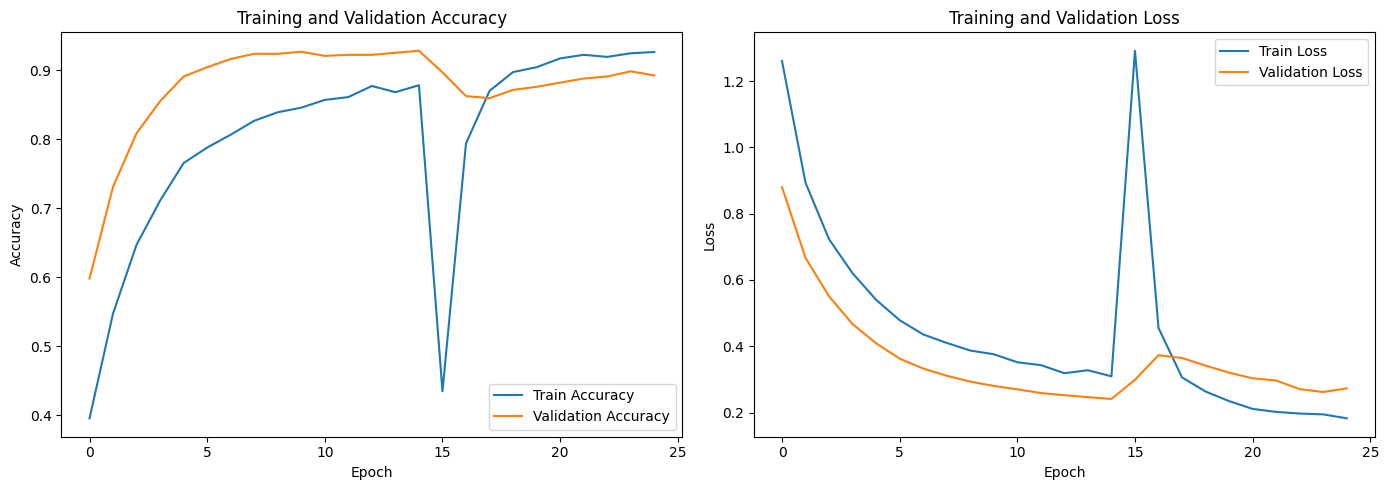

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history, history_fine=None):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Se houver fine tuning, concatenar históricos
    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']
        epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # ---------------------------
    # Accuracy
    # ---------------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc)
    plt.plot(epochs_range, val_acc)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train Accuracy', 'Validation Accuracy'])

    # ---------------------------
    # Loss
    # ---------------------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss)
    plt.plot(epochs_range, val_loss)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Loss', 'Validation Loss'])

    plt.tight_layout()
    plt.show()


# Executar
plot_training_history(history, history_fine)


# MATRIZ DE CONFUSÃO

In [14]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[125   1   7]
 [  1 202  60]
 [  0   3 270]]
              precision    recall  f1-score   support

       covid       0.99      0.94      0.97       133
      normal       0.98      0.7

# PREDIÇÃO FINAL CORRETA

In [19]:
labels_dict = dict(enumerate(class_names))

def predict_image(path):
    img = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    index = np.argmax(pred)

    print("Probabilidades:", pred)
    print("Classe prevista:", labels_dict[index])

# TESTE
predict_image("data/raw/covid/COVID-19 (1).png")
predict_image("data/raw/normal/NORMAL (1).png")
predict_image("data/raw/pneumonia/VIRAL PNEUMONIA (1).png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Probabilidades: [[7.3721695e-01 6.1249069e-05 2.6272181e-01]]
Classe prevista: covid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Probabilidades: [[0.00400943 0.8761845  0.1198061 ]]
Classe prevista: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Probabilidades: [[2.835540e-04 5.975420e-05 9.996568e-01]]
Classe prevista: pneumonia


In [ ]:
import logging
import shutil
from pathlib import Path
from typing import List


class GitHubSizeLimitError(Exception):
    """Erro relacionado ao controle de tamanho para GitHub."""
    pass


class DatasetSizeController:
    """
    Controla o tamanho da pasta data/raw baseado no limite máximo
    recomendado para push no GitHub.
    """

    GITHUB_FILE_LIMIT_MB = 100  # Hard limit por arquivo

    def __init__(
        self,
        raw_dir: str,
        storage_dir: str,
        max_repo_size_mb: int = 90  # Limite seguro para push
    ):
        self.raw_dir = Path(raw_dir)
        self.storage_dir = Path(storage_dir)
        self.max_repo_size_bytes = max_repo_size_mb * 1024 * 1024
        self._configure_logger()

    def _configure_logger(self):
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s | %(levelname)s | %(message)s",
            handlers=[
                logging.FileHandler("dataset_size_controller.log"),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)

    def validate_directories(self):
        if not self.raw_dir.exists():
            raise GitHubSizeLimitError(f"Diretório RAW não encontrado: {self.raw_dir}")

        self.storage_dir.mkdir(parents=True, exist_ok=True)

    def get_all_files(self) -> List[Path]:
        return [file for file in self.raw_dir.rglob("*") if file.is_file()]

    def calculate_total_size(self) -> int:
        return sum(file.stat().st_size for file in self.get_all_files())

    def move_file(self, file: Path):
        relative_path = file.relative_to(self.raw_dir)
        destination = self.storage_dir / relative_path
        destination.parent.mkdir(parents=True, exist_ok=True)
        shutil.move(str(file), str(destination))
        self.logger.info(f"Movido: {file.name} → storage")

    def enforce_file_limit(self):
        """
        Garante que nenhum arquivo individual ultrapasse 100MB.
        """
        for file in self.get_all_files():
            file_size_mb = file.stat().st_size / (1024 * 1024)
            if file_size_mb > self.GITHUB_FILE_LIMIT_MB:
                self.logger.warning(
                    f"Arquivo excede 100MB ({file_size_mb:.2f}MB): {file.name}"
                )
                self.move_file(file)

    def reduce_repo_size(self):
        """
        Reduz tamanho total da pasta raw até ficar abaixo do limite.
        Move arquivos maiores primeiro.
        """
        files = self.get_all_files()

        # Ordena do maior para o menor
        files.sort(key=lambda f: f.stat().st_size, reverse=True)

        current_size = self.calculate_total_size()
        self.logger.info(f"Tamanho atual: {current_size / (1024 * 1024):.2f} MB")

        for file in files:
            if current_size <= self.max_repo_size_bytes:
                break

            file_size = file.stat().st_size
            self.move_file(file)
            current_size -= file_size

        self.logger.info(
            f"Tamanho final: {current_size / (1024 * 1024):.2f} MB"
        )

    def execute(self):
        try:
            self.logger.info("Iniciando controle de tamanho para GitHub...")
            self.validate_directories()

            # 1️⃣ Garante que nenhum arquivo individual ultrapasse 100MB
            self.enforce_file_limit()

            # 2️⃣ Garante que o total fique abaixo do limite configurado
            self.reduce_repo_size()

            self.logger.info("Controle concluído com sucesso.")

        except Exception as e:
            self.logger.critical(f"Erro crítico: {e}")
            raise GitHubSizeLimitError from e


if __name__ == "__main__":
    controller = DatasetSizeController(
        raw_dir="data/raw",
        storage_dir="data/storage",
        max_repo_size_mb=90  # ajuste conforme necessário
    )
    controller.execute()


2026-02-12 12:17:27,832 | INFO | Iniciando controle de tamanho para GitHub...
2026-02-12 12:17:29,427 | INFO | Tamanho atual: 1247.59 MB
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u2192' in position 58: character maps to <undefined>
Call stack:
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\Desktop\covid-19\data-science-machine-learning-for